First, let's do word2vec with 'normal' text

In [1]:
from gensim.models.word2vec import Word2Vec
from gensim.models import word2vec
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import numpy as np 

STOP = set(stopwords.words("english"))
REMOVE = set(["!","(",")",":",".",";",",",'"',"?","-",">","_"])


df = pd.read_csv('../Goodreads_visualization/goodreads_export.csv')
cleaned_df = df[df["My Rating"] != 0]


html_clean = re.compile('<.*?>')
gr_clean = re.compile('\[.*?\]')

all_my_words = []

reviews = cleaned_df["My Review"]

num_reviews = 0
num_words = 0
for row in reviews:
    if pd.isnull(row):
        continue
    review = row.lower()
    if not review:
        # empty review
        continue
    # clean strings
    cleaned_review = re.sub(html_clean, '', review)
    cleaned_review = re.sub(gr_clean, '', cleaned_review)
    new_review = []
    for x in cleaned_review.split(' '):
        if x in STOP: continue
        if x in REMOVE: continue
        new_review.append(x)
    new_review = ' '.join(new_review)
    
    all_my_words += new_review.split('.')
    num_reviews += 1



let's put these sentences into a dumb text file for the helper, just as an example

In [2]:
text = open('simple_text.txt','w')
for element in all_my_words:
    text.write('%s.\n'%element)

In [3]:
from gensim.models.word2vec import LineSentence
sentences = LineSentence(text.name) 
model = Word2Vec(sentences, size=100, window=4, min_count=5)

In [4]:
vocab = list(model.vocab.keys())
vocab[:10]

['confusing',
 '8',
 'anything,',
 'them,',
 'highly',
 'novella',
 'took',
 'history,',
 'escaped',
 'description']

In [5]:
model['physics']

array([ 0.02590463,  0.05325259,  0.00275839, -0.02335821, -0.0021469 ,
        0.00749045, -0.04389399,  0.01700118, -0.00811095,  0.031775  ,
       -0.02971643, -0.02754352,  0.00948112, -0.01186801, -0.0017621 ,
        0.0011061 , -0.00807445,  0.01756881,  0.061256  ,  0.02924409,
        0.0099775 ,  0.03155666, -0.01586835, -0.01067527, -0.04608267,
        0.02817214,  0.00196514,  0.02461084, -0.00582369,  0.11048271,
        0.02120005, -0.04655095, -0.0654763 ,  0.05405751,  0.05760092,
       -0.00156674, -0.05828641,  0.02093396,  0.02653268, -0.0292282 ,
       -0.06003998, -0.03734865, -0.04022611,  0.01959871,  0.00404786,
       -0.00465561, -0.02315675,  0.05392883, -0.02473005, -0.01621924,
       -0.00241546, -0.00201591, -0.01784706,  0.01396601,  0.01072223,
       -0.00744795,  0.03499661,  0.01595387,  0.05096153,  0.02115347,
       -0.0189    ,  0.00876939,  0.00991265,  0.00485152, -0.07494608,
       -0.03111615,  0.01724795,  0.00794527, -0.00816187, -0.02

In [6]:
model.most_similar_cosmul(positive=['nazis', 'japan'])

[('the', 0.9963245987892151),
 ('around', 0.9962689280509949),
 ('less', 0.996261715888977),
 ('years', 0.9962410926818848),
 ('things', 0.9962348937988281),
 ('lot', 0.9962292909622192),
 ('need', 0.9962226748466492),
 ('story', 0.9962186813354492),
 ('starts', 0.9962095022201538),
 ('take', 0.996208906173706)]

In [7]:
model.similarity('book', 'novel')

0.99948381242476159

Exciting! Are other pairs more dissimilar?

In [8]:
import random
similarities = []
for i in range(1,100):
    one, other = random.choice(vocab), random.choice(vocab)

    similarities.append(model.similarity(one, other))

In [9]:
np.mean(similarities), np.median(similarities)

(0.97340578733299954, 0.98706711297229521)

Welp that's not good. I guess the training corpus is too small...

In [10]:
model.syn0

array([[  3.00974160e-01,   6.87568307e-01,   2.25740969e-02, ...,
         -1.06893435e-01,   8.04017931e-02,   1.47196159e-01],
       [  2.77204245e-01,   6.41609013e-01,   2.73348484e-02, ...,
         -1.00759573e-01,   6.77796975e-02,   1.36412725e-01],
       [  2.74293721e-01,   6.22721732e-01,   2.16171890e-02, ...,
         -1.01019360e-01,   6.91562518e-02,   1.27807602e-01],
       ..., 
       [  1.27614932e-02,   2.32411809e-02,   1.53399154e-03, ...,
         -7.35794660e-03,   3.31353222e-04,   2.68854876e-03],
       [  1.42780505e-02,   2.22719088e-02,  -1.50333496e-03, ...,
         -4.20227501e-04,  -1.96805643e-03,   1.83127099e-03],
       [  1.00261848e-02,   3.60426456e-02,   3.44293192e-03, ...,
         -9.25957877e-03,   4.07849299e-03,   9.70157422e-03]], dtype=float32)

The above are the weights you can use in embeddings

-----------------------

Now let's look at DNA!

In [11]:
import dna2vec

First a look at how dna2vec does it:

In [12]:
class Learner:
    def __init__(self, out_fileroot, context_halfsize, gensim_iters, vec_dim):
        self.logger = logbook.Logger(self.__class__.__name__)
        assert(word2vec.FAST_VERSION >= 0)
        self.logger.info('word2vec.FAST_VERSION (should be >= 0): {}'.format(word2vec.FAST_VERSION))
        self.model = None
        self.out_fileroot = out_fileroot
        self.context_halfsize = context_halfsize
        self.gensim_iters = gensim_iters
        self.use_skipgram = 1
        self.vec_dim = vec_dim

        self.logger.info('Context window half size: {}'.format(self.context_halfsize))
        self.logger.info('Use skipgram: {}'.format(self.use_skipgram))
        self.logger.info('gensim_iters: {}'.format(self.gensim_iters))
        self.logger.info('vec_dim: {}'.format(self.vec_dim))

    def train(self, kmer_seq_generator):
        self.model = word2vec.Word2Vec(
            sentences=kmer_seq_generator,
            size=self.vec_dim,
            window=self.context_halfsize,
            min_count=5,
            workers=4,
            sg=self.use_skipgram,
            iter=self.gensim_iters)

        # self.logger.info(model.vocab)

    def write_vec(self):
        out_filename = '{}.w2v'.format(self.out_fileroot)
        self.model.save_word2vec_format(out_filename, binary=False)


--------------------------------

The trained table looks like this (some random input data from my projects)

    1344 12
    AAA 0.798623 0.340167 -0.106002 0.479023 -0.512316 -0.204932 -0.909642 0.929776 -0.526895 -0.487418 0.652579 -0.041673
    TTT -0.430355 0.507353 0.204868 -0.396864 0.594459 -0.879607 -0.070906 1.065970 -0.216547 0.540595 0.742848 -0.213119
    AAAA 0.916474 0.360498 -0.201165 0.450726 -0.627372 -0.232655 -1.043633 1.079020 -0.585594 -0.505746 0.719241 0.046239
    TTTT -0.604012 0.578508 0.240181 -0.476954 0.605583 -0.960840 -0.079009 1.184651 -0.243861 0.608393 0.795853 -0.286772
    TTTTT -0.625304 0.602461 0.296689 -0.482694 0.649928 -0.997988 -0.065473 1.091690 -0.250700 0.741902 0.868796 -0.313275
    AAAAA 1.029531 0.364190 -0.265436 0.437347 -0.723385 -0.299899 -1.087821 1.122777 -0.636950 -0.578345 0.761875 0.069213
    ATT -0.490559 0.496848 -0.300972 -0.190906 0.170407 -0.613530 -0.456763 0.833760 -0.632226 0.541257 0.759477 -0.018878
    AAT 0.028495 0.360433 -0.458956 0.125764 -0.013972 -0.417648 -0.925049 0.953009 -0.534955 -0.186829 0.600540 0.346013


Now load this into python, and later Keras

In [13]:
from gensim.models import word2vec
word_vectors = word2vec.Word2Vec.load_word2vec_format('./dna2vec-20170621-0833-k3to5-12d-4c-6Mbp-sliding-nqR.w2v')

In [14]:
word_vectors.syn0

array([[ 0.79862303,  0.34016699, -0.106002  , ..., -0.487418  ,
         0.65257901, -0.041673  ],
       [-0.43035501,  0.50735301,  0.204868  , ...,  0.540595  ,
         0.74284798, -0.213119  ],
       [ 0.91647398,  0.36049801, -0.20116501, ..., -0.50574601,
         0.71924102,  0.046239  ],
       ..., 
       [ 0.76107103,  0.83726299, -0.28360999, ...,  0.170651  ,
         0.103405  , -0.71069998],
       [ 0.89855403,  0.8168    , -0.37794799, ...,  0.32508701,
         0.61397099, -0.39332399],
       [ 0.814578  ,  0.86901098, -0.498676  , ...,  0.21636599,
         0.474002  , -0.49750999]], dtype=float32)

That's the weights for Keras!

In [15]:
word_vectors.syn0.shape

(1344, 12)

In [16]:
word_vectors.most_similar(positive=['AAA'], negative=['TTT'])

[('AAAAA', 0.6307621002197266),
 ('AAAA', 0.6196656227111816),
 ('AAAGG', 0.597085177898407),
 ('GAAAA', 0.5835936069488525),
 ('AGGAA', 0.5639663338661194),
 ('AAAAG', 0.5594942569732666),
 ('CAAAA', 0.5461493730545044),
 ('GAAA', 0.5357614159584045),
 ('AAAAC', 0.5209873914718628),
 ('GGAAA', 0.5187864303588867)]

In [17]:
word_vectors.most_similar(positive=['AAA'])

[('AAAA', 0.997001051902771),
 ('AAAAA', 0.9936331510543823),
 ('AATAA', 0.9240623712539673),
 ('TAAAA', 0.9036520719528198),
 ('TAAA', 0.8960134983062744),
 ('GAAAA', 0.8902114629745483),
 ('AAAT', 0.8800619840621948),
 ('AAAAT', 0.8783645629882812),
 ('GAAA', 0.8714821338653564),
 ('CAAAA', 0.869722843170166)]

In [18]:
word_vectors.similarity('AGAAT','AAGTA')

0.37256660513788192

More promising! At least no 99% as above....

----------------

Let's compare with Needleman Wunsch, an alignment algorithm

In [19]:
from Bio import pairwise2
pairwise2.align.globalxx("AGAAT", "AAGTA")

[('AGAA-T-', '--AAGTA', 3.0, 0, 7),
 ('AGAA-T-', 'A--AGTA', 3.0, 0, 7),
 ('AGAA-T-', 'A-A-GTA', 3.0, 0, 7),
 ('AGAAT-', 'A-AGTA', 3.0, 0, 6),
 ('A-GAAT-', 'AAG--TA', 3.0, 0, 7),
 ('-AGAAT-', 'AAG--TA', 3.0, 0, 7),
 ('AGA--AT', 'A-AGTA-', 3.0, 0, 7),
 ('A-GA-AT', 'AAG-TA-', 3.0, 0, 7),
 ('-AGA-AT', 'AAG-TA-', 3.0, 0, 7),
 ('A-GAAT', 'AAGTA-', 3.0, 0, 6),
 ('-AGAAT', 'AAGTA-', 3.0, 0, 6),
 ('A-G-AAT', 'AAGTA--', 3.0, 0, 7),
 ('-AG-AAT', 'AAGTA--', 3.0, 0, 7)]

In [20]:
3.0/7

0.42857142857142855

Kind of close? 42 % to 37%....

In [21]:
from datasketch import MinHash
import random
nws = []
sims = []
sketches = []
counter = 0
outside_counter = 0

keys = list(word_vectors.vocab.keys())
for i in range(1,1000):
    #print(word_vectors.vocab.keys())
    a = random.choice(keys)
    b = random.choice(keys)
    if a == b: continue
    if len(a) != len(b) != 5: continue
    # get similarity via needleman-wunsch
    new_score = pairwise2.align.globalxx(a, b)[0]
    # ('CCAC--T', '-CA-AAT', 3.0, 0, 7)
    score, length = new_score[2], new_score[-1]
    score += 1

    nws.append(score)

    # get from dna2vec
    similarity = word_vectors.similarity(a, b) # 0.3
    sims.append(similarity)

    # get from minhash
    m1, m2 = MinHash(), MinHash()
    for d in a:
        m1.update(d.encode('utf8'))
    for d in b:
        m2.update(d.encode('utf8'))
    jaccard = m1.jaccard(m2)

    sketches.append(jaccard)

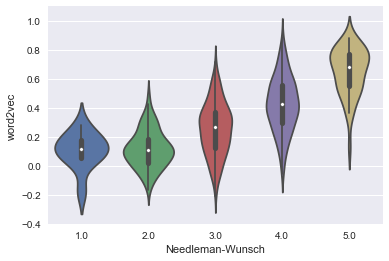

In [22]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Needleman-Wunsch':nws, 'word2vec':sims})
%matplotlib inline
sns.violinplot(x='Needleman-Wunsch', y='word2vec', data=df);

In [23]:
import scipy
print(scipy.stats.pearsonr(nws, sims), scipy.stats.pearsonr(sketches, sims), scipy.stats.pearsonr(nws, sketches))

(0.58097157250417764, 4.240821694880841e-75) (0.37885759750021414, 2.3789707907957134e-29) (0.58060023892518331, 5.5360242715689705e-75)


wat. was expecting something higher. Let's try t-SNE

[[-0.17905501  1.31028903  0.25527099]
 [ 0.29710999  1.24941504 -0.51987797]
 [ 0.248716    1.53722298 -0.417088  ]]


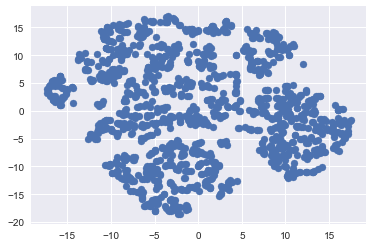

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = word_vectors[word_vectors.vocab]
print(X[0:3,0:3])

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

Let's load the pretrained huge wordvectors from the paper (trained on human genome)

In [25]:
word_vectors = word2vec.Word2Vec.load_word2vec_format('./dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v')

Needleman Wunsch vs word2vec similarities: 0.549490891705, 
      MinHash vs word2vec similarities: -0.0298490315182,
      Needleman Wunsch vs MinHash: 0.170673690321,
      MinHash vs. Cosine Similarity: -0.029849041001,
      Needleman Wunsch vs Cosine Similarity: 0.54949089627,
      word2vec vs Cosine Similarity: 0.999999996318


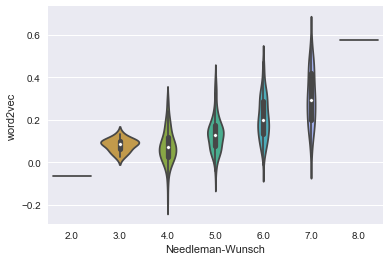

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

nws = []
sims = []
sketches = []
cosines = []


keys = list(word_vectors.vocab.keys())
for i in range(1,1000):
    #print(word_vectors.vocab.keys())
    a = random.choice(keys)
    b = random.choice(keys)
    if a == b:
        continue
    if len(a) + len(b) != 16:
        continue

    # get similarity via needleman-wunsch
    new_score = pairwise2.align.globalxx(a, b)[0]
    # ('CCAC--T', '-CA-AAT', 3.0, 0, 7)
    score, length = new_score[2], new_score[-1]
    new_score = score + 1
    nws.append(new_score)

    # get from cosine similarity
    cosine = cosine_similarity(word_vectors[a].reshape(1,-1), word_vectors[b].reshape(1,-1))[0][0]
    cosines.append(cosine)

    # get from dna2vec
    similarity = word_vectors.similarity(a, b) # 0.3
    sims.append(similarity)

    # get from minhash
    m1, m2 = MinHash(), MinHash()
    for d in a:
        m1.update(d.encode('utf8'))
    for d in b:
        m2.update(d.encode('utf8'))
    jaccard = m1.jaccard(m2)

    sketches.append(jaccard)
    counter += 1


print('''Needleman Wunsch vs word2vec similarities: %s, 
      MinHash vs word2vec similarities: %s,
      Needleman Wunsch vs MinHash: %s,
      MinHash vs. Cosine Similarity: %s,
      Needleman Wunsch vs Cosine Similarity: %s,
      word2vec vs Cosine Similarity: %s'''%(
      scipy.stats.pearsonr(nws, sims)[0], 
      scipy.stats.pearsonr(sketches, sims)[0], 
      scipy.stats.pearsonr(nws, sketches)[0], 
      scipy.stats.pearsonr(sketches, cosines)[0],
      scipy.stats.pearsonr(nws, cosines)[0],
      scipy.stats.pearsonr(sims, cosines)[0]
))

df = pd.DataFrame({'Needleman-Wunsch':nws, 'word2vec':sims})
sns.violinplot(x='Needleman-Wunsch', y='word2vec', data=df);

Now check the first NEIGHBOR only

In [27]:
counter = 0
nws = []
w2v = []
sketches = []

for a in word_vectors.vocab:
    if len(a) != 8: continue
        
    neighbors = word_vectors.most_similar_cosmul(a)
    neighbor = ''
    for  n in neighbors:
        # n = ('CTTTCCT', 0.929522693157196)
        if len(n[0]) == len(a):
            neighbor = n
            break
    if not neighbor: 
        continue
    
    new_score = pairwise2.align.globalxx(a, neighbor[0])[0]
    # ('CCAC--T', '-CA-AAT', 3.0, 0, 7)
    score, length = new_score[2], new_score[-1]
    score += 1
    if counter < 5:
        print('Sequence %s Neighbor %s'%(a, neighbor))
        print('Needleman Wunsch: %s'%score)
        print('-------')
    nws.append(score)
    other_score = neighbor[1]
    w2v.append(other_score)
    
    # get from minhash
    m1, m2 = MinHash(), MinHash()
    for d in a:
        m1.update(d.encode('utf8'))
    for d in neighbor[0]:
        m2.update(d.encode('utf8'))
    jaccard = m1.jaccard(m2)

    sketches.append(float('%.1f'%jaccard))
    
    if counter == 1000:
        break
    counter += 1

scipy.stats.spearmanr(nws, w2v)

Sequence AGATGCAC Neighbor ('GATGCACA', 0.8849484920501709)
Needleman Wunsch: 8.0
-------
Sequence CTGCATAC Neighbor ('CTGCATAT', 0.8692834377288818)
Needleman Wunsch: 8.0
-------
Sequence GTATGATA Neighbor ('AGTATGAT', 0.8735715746879578)
Needleman Wunsch: 8.0
-------
Sequence CGGGGGGG Neighbor ('CGGCGGGG', 0.9540440440177917)
Needleman Wunsch: 8.0
-------
Sequence ATAGGGGC Neighbor ('ATAGGGGG', 0.9357842206954956)
Needleman Wunsch: 8.0
-------


SpearmanrResult(correlation=0.0049777762026951312, pvalue=0.87501315933465107)

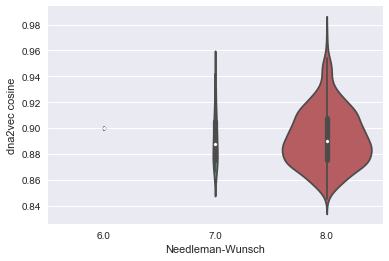

In [28]:
df = pd.DataFrame({'Needleman-Wunsch':nws, 'dna2vec cosine':w2v, 'MinHash':sketches})
sns.violinplot(x='Needleman-Wunsch', y='dna2vec cosine', data=df, scale='count');


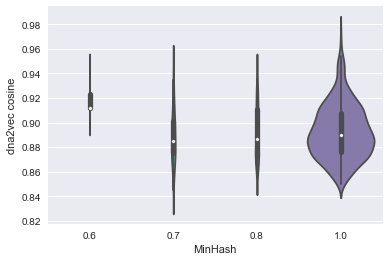

In [29]:
g = sns.violinplot(x='MinHash', y='dna2vec cosine', data=df, scale='count');

Niiiiiiiiiice. So for close neighbors MinHash and Needleman-Wunsch seem to correlate, but not for distant neighbors, interesting

In [30]:
df.describe()

,MinHash,Needleman-Wunsch,dna2vec cosine
count,1001.000000,1001.000000,1001.000000
mean,0.973826,7.949051,0.892468
std,0.079714,0.228914,0.022032
min,0.600000,6.000000,0.844782
25%,1.000000,8.000000,0.875647
50%,1.000000,8.000000,0.890206
75%,1.000000,8.000000,0.907552
max,1.000000,8.000000,0.975248


Welp that's weird. By now I think that neighbors in the dna2vec space don't necessarily have to be related by their bases.

TO CHECK:
- what are the neighbors that have low NW scores? Are they functionally related, or are their sequences conserved? Can I find conservation islands this way?
- why is it that close neighbors have better NW/MinHash score correlation than distant neighbors?

In [31]:
weights = word_vectors.syn0

from keras.layers import Embedding
from keras.engine import Input

layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights], trainable=False)
layer

Using TensorFlow backend.


IMPORTANT to set trainable to False, else Keras is allowed to change our word2vec input weights!

We can either use an LSTM or convolutional layers here.

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html